# Data Preprocessing

Data preprocessing encompasses tasks involved with the cleaning, transformation, reduction, and discretization of data, with the objective of producing data that is more useful for and representative of the problem we are trying to solve. Common tasks that may be applied during data preprocessing include filling in or imputing missing values, smoothing and binning data, removing outliers, sampling values, and normalizing and standardizing data.

In this notebook, we will look at how we can use `matplotlib`, `NumPy`, `pandas`, and `scikit-learn` to help us preprocess data with Python.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Working with Missing Data

pandas provides support for respresenting, detecting, and filling missing values.

We begin by defining a pandas dataframe that contains some cells with missing values. Note that in addition to allowing us to create dataframes from a variety of files, pandas also supports explicit declaration of a DataFrame. We can pass in a dictionary of lists, the values of each list representing column values:

In [2]:
incomplete_df = pd.DataFrame(
    {'id': [1, 2, 3, 3, 2],
     'type': ['one', 'one', 'two', 'three', 'two',],
     'amount': [np.nan, 42, np.nan, 5, 500]
    }, columns=['id', 'type', 'amount'])

The 'amount' column is the only one with missing values.

In [3]:
incomplete_df

,id,type,amount
0,1,one,NaN
1,2,one,42.0
2,3,two,NaN
3,3,three,5.0
4,2,two,500.0


We can identify missing values using the `isnull()` method, which returns `True` for cells with missing values:

In [4]:
incomplete_df.isnull()

,id,type,amount
0,False,False,True
1,False,False,False
2,False,False,True
3,False,False,False
4,False,False,False


Recall that summary statistics and arithmetic with missing data is natively supported by pandas. Let's define two series, both containing some missing values. We will extract the first Series from the amount column of our DataFrame above and we'll create the second series from a list:

In [5]:
A = incomplete_df['amount']
B = pd.Series(data=[np.nan, 42, np.nan, 5, 500])

In [6]:
A

0      NaN
1     42.0
2      NaN
3      5.0
4    500.0
Name: amount, dtype: float64

In [7]:
B

0      NaN
1     42.0
2      NaN
3      5.0
4    500.0
dtype: float64

The mean is computed normally, with missing values ignored:

In [8]:
A.mean()

182.33333333333334

Functions to find the minimum, maximum, standard deviation, and variance all work even when data are missing:

In [9]:
B.min()

5.0

In [10]:
B.max()

500.0

In [11]:
B.std()

275.7287314251696

In [12]:
B.var()

76026.33333333331

We can also perform element-wise arithmetic operations between series with missing data. Note that by definition the result of any operation that involves missing values is `NaN`:

In [13]:
A + B

0       NaN
1      84.0
2       NaN
3      10.0
4    1000.0
dtype: float64

#### Dropping Missing Values

Recall that `pandas` has a function that allows you to drop any rows in a DataFrame (or elements in a Series) that contain a missing value.

In [14]:
A

0      NaN
1     42.0
2      NaN
3      5.0
4    500.0
Name: amount, dtype: float64

In [15]:
A.dropna()

1     42.0
3      5.0
4    500.0
Name: amount, dtype: float64

### Filling Missing Values

Very often, you may wish to fill in missing values rather than simply dropping them. Of course, `pandas` also has that functionality. 

#### Filling by Value

For example, we could fill missing values with a scalar number, as shown below.

In [16]:
A.fillna(-1)

0     -1.0
1     42.0
2     -1.0
3      5.0
4    500.0
Name: amount, dtype: float64

That actually works with any data type.

In [17]:
A.fillna('missing data')

0    missing data
1              42
2    missing data
3               5
4             500
Name: amount, dtype: object

#### Filling with Average Value

We can use this functionality to fill in the gaps with the average value computed across the non-missing values.

In [18]:
A.fillna(A.mean())

0    182.333333
1     42.000000
2    182.333333
3      5.000000
4    500.000000
Name: amount, dtype: float64

Even better, if we want to fill in the gaps with mean values of corresponding *id's* (recall our initial dataframe printed below), the following code performs that seemingly complex task.

In [19]:
incomplete_df

,id,type,amount
0,1,one,NaN
1,2,one,42.0
2,3,two,NaN
3,3,three,5.0
4,2,two,500.0


In [20]:
# Fill in gaps in the 'amount' column with means obtained from corresponding id's in the first column.
incomplete_df['amount'].fillna(incomplete_df.groupby('id')['amount'].transform('mean'), inplace=True)
incomplete_df

,id,type,amount
0,1,one,NaN
1,2,one,42.0
2,3,two,5.0
3,3,three,5.0
4,2,two,500.0


In [21]:
# If there is no corresponding id, simply use the overall mean.
incomplete_df['amount'].fillna(incomplete_df['amount'].mean(), inplace=True)
incomplete_df

,id,type,amount
0,1,one,138.0
1,2,one,42.0
2,3,two,5.0
3,3,three,5.0
4,2,two,500.0


#### Backward and Forward Filling

You can fill values forwards and backwards with the flags *pad* / *ffill* and *bfill* / *backfill*

In [22]:
B

0      NaN
1     42.0
2      NaN
3      5.0
4    500.0
dtype: float64

In [23]:
B.fillna(method='pad')

0      NaN
1     42.0
2     42.0
3      5.0
4    500.0
dtype: float64

We can set a limit if we only want to replace consecutive gaps.

In [24]:
B.fillna(method='bfill', limit=1)

0     42.0
1     42.0
2      5.0
3      5.0
4    500.0
dtype: float64

#### Imputing Missing Values

In [25]:
B

0      NaN
1     42.0
2      NaN
3      5.0
4    500.0
dtype: float64

There is also a function that does linear interpolation. The keyword *method* gives you access to more interpolation methods, some of which require `SciPy`.

We can use linear interpolation:

In [26]:
B.interpolate()  # by default, method='linear'

0      NaN
1     42.0
2     23.5
3      5.0
4    500.0
dtype: float64

We can use nearest-neighbor interpolation:

In [27]:
B.interpolate(method='nearest')

0      NaN
1     42.0
2     42.0
3      5.0
4    500.0
dtype: float64

We can use quadratic interpolation:

In [28]:
B.interpolate(method='quadratic')

0           NaN
1     42.000000
2   -147.666667
3      5.000000
4    500.000000
dtype: float64

#### Comparison of Methods to Fill Missing Values

Below we compare and contrast these three methods.

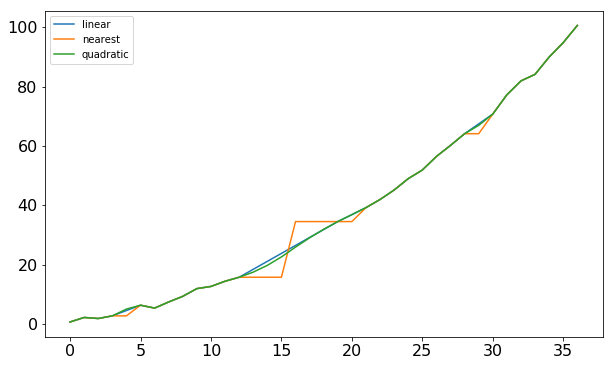

In [29]:
s = pd.Series(np.arange(1, 10.1, .25) ** 2 + np.random.randn(37))
bad = np.array([4, 13, 14, 15, 16, 17, 18, 20, 29])
s[bad] = np.nan
methods = ['linear', 'nearest', 'quadratic']
df = pd.DataFrame({m: s.interpolate(method=m) for m in methods})
out = df.plot(figsize=(10, 6), fontsize=16)

Notice that the methods have different assumptions and characteristics. Some, like `nearest`, are more discrete, only generating values that already exist. Others, like `linear` and `quadratic`, are more smooth, generating intermediate values using different assumptions.

## Sampling Instances

We begin by defining a pandas DataFrame. Note that in addition to allowing us to create a DataFrame from a variety of types of files, pandas also supports explicit declaration of a DataFrame.

In [30]:
df = pd.DataFrame(np.arange(5 * 4).reshape(5, 4))
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


#### Random Sampling without Replacement

To select a random subset without replacement, one way is to slice off the first *k* elements of the array returned by permutation, where *k* is the desired subset size. Here, we use the 'take' method, which retrieves elements along a given axis at the given indices. Using this function, we slice off the first three elements:

In [31]:
df_sampled_without_replacement = df.take(np.random.permutation(len(df))[:3])
df_sampled_without_replacement

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
3,12,13,14,15


#### Random Sampling with Replacement

To generate a sample with replacement, we can draw random integers.

In [32]:
sampler = np.random.randint(0, len(df), size=3)
sampler

array([0, 4, 4])

These random integers can be used as input for the 'take' method, which is then used to sample the data. Since the random integers consistuting the array may be repeated, the rows sampled by this method may also be repeated -- or, in other words, sampled with replacement.

In [33]:
df_sampled_with_replacement = df.take(sampler)
df_sampled_with_replacement

,0,1,2,3
0,0,1,2,3
4,16,17,18,19
4,16,17,18,19


## Data Normalization and Standardization

Aside from filling in missing values and sampling data, we may also want to normalize or standardize our data.

In [34]:
df_norm = df / df.sum().astype('float')
df_norm

,0,1,2,3
0,0.0,0.022222,0.04,0.054545
1,0.1,0.111111,0.12,0.127273
2,0.2,0.200000,0.20,0.200000
3,0.3,0.288889,0.28,0.272727
4,0.4,0.377778,0.36,0.345455


In [35]:
perm = np.random.permutation(len(df))
perm

array([2, 4, 0, 1, 3])

In [36]:
df_permuted = df.take(perm)
df_permuted

,0,1,2,3
2,8,9,10,11
4,16,17,18,19
0,0,1,2,3
1,4,5,6,7
3,12,13,14,15


In [37]:
df_permuted_norm = df_permuted / df_permuted.sum().astype('float')
df_permuted_norm

,0,1,2,3
2,0.2,0.200000,0.20,0.200000
4,0.4,0.377778,0.36,0.345455
0,0.0,0.022222,0.04,0.054545
1,0.1,0.111111,0.12,0.127273
3,0.3,0.288889,0.28,0.272727


## Example with the Iris Dataset

We will use the "Iris dataset" as an example for employing these methods. The Iris flower dataset or Fisher's Iris dataset is a well-known multivariate dataset introduced by Sir Ronald Fisher in 1936 as an example of discriminant analysis, a method for finding a linear combination of features that characterizes or separates two or more classes of objects or events. Fischer is famous for helping to develop the foundation for modern statistical science, and his method of linear discriminant analysis is perhaps the earliest classification method.

Let's fetch the Iris dataset from the UCI Machine Learning repository.

In [38]:
fileURL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df_iris = pd.read_csv(fileURL, names=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Name'], header=None)

In [39]:
df_iris.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


When read directly from the UCI Machine Learning repository, the Iris dataset has an extra line at the bottom that is read by pandas as a row of null values. Let's drop this final line:

In [40]:
df_iris = df_iris.dropna()

To visualize this data, we can create a scatter plot matrix. In pandas, the scatter_matrix function generates a matrix of pairwise scatterplots, optiorally with histograms (or kernel density estimates) on the diagonal. Here's the scatter plot matrix with histograms on the diagonal:

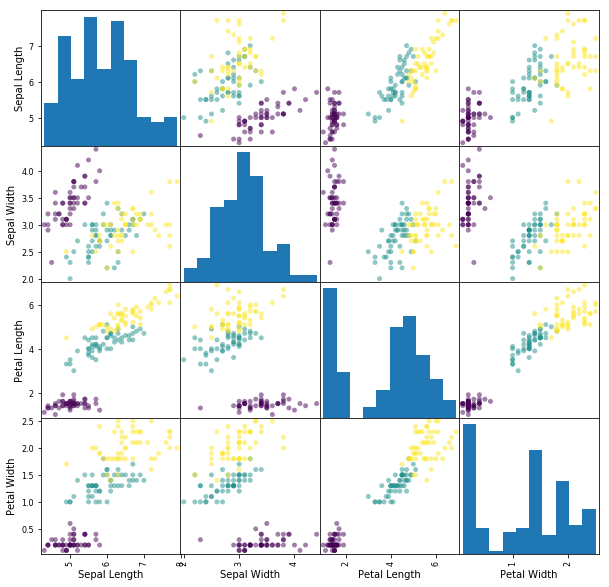

In [41]:
colors = pd.factorize(df_iris['Name'])[0]  # get numeric class value for each row

# Plot each species in a scatter matrix.
pl1 = pd.plotting.scatter_matrix(df_iris, figsize=(10, 10), c=colors, s=100)

We can also use boxplots to visualize the variability of each feature:

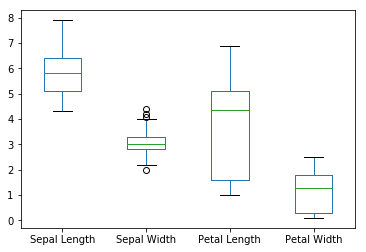

In [42]:
pl2 = df_iris.boxplot(grid=False)

Notice that Sepal Width has several outliers. In certain circumstances, it may be beneficial to remove these outliers. In this example, we interpolate over these outliers, replacing them with values that are more likely given the other data:

In [43]:
df_iris['Sepal Width'] = np.where((df_iris['Sepal Width'] > 4) | (df_iris['Sepal Width'] < 2.1),
                                  np.nan, df_iris['Sepal Width'])
df_iris['Sepal Width'] = df_iris['Sepal Width'].interpolate()

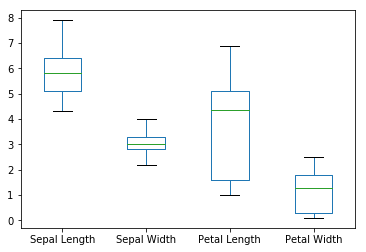

In [44]:
pl3 = df_iris.boxplot(grid=False)

With outliers removed, we may now be interested in sampling the data. Here, we use sampling with replacement to select 100 instances from the dataset:

In [45]:
sampler = np.random.randint(0, len(df_iris), size=100)
df_iris = df_iris.take(sampler)
df_iris.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Name
92,5.8,2.6,4.0,1.2,Iris-versicolor
124,6.7,3.3,5.7,2.1,Iris-virginica
13,4.3,3.0,1.1,0.1,Iris-setosa
122,7.7,2.8,6.7,2.0,Iris-virginica
17,5.1,3.5,1.4,0.3,Iris-setosa


Now with the data cleaned and sampled, we may be interested in standardizing the data. Here, we use z-score normalization to rescale each feature. z-score normalization converts all features to a common scale with an average of zero and standard deviation of one (note that the `ddof` parameter refers to delta degrees of freedom, and is 1 because we are computing the standard deviation over a sample, not a population):

In [46]:
names = df_iris['Name']
df_iris = df_iris.groupby('Name').transform(lambda x: (x - x.mean()) / x.std(ddof=1))
df_iris['Name'] = names  # reinsert class name column

Using boxplots once again, now we can see that each feature has been normalized, with each feature displaying an average of zero and a standard deviation of one:

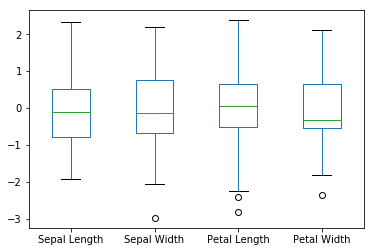

In [47]:
pl4 = df_iris.boxplot(grid=False)

Visualizating the data with a scatter plot matrix once again, we can now observe dramatic changes in the data. Each feature now displays a histogram that more closely resembles a normal distribution. Additionally, the separation previously observable in the scatter plots is now largely absent.

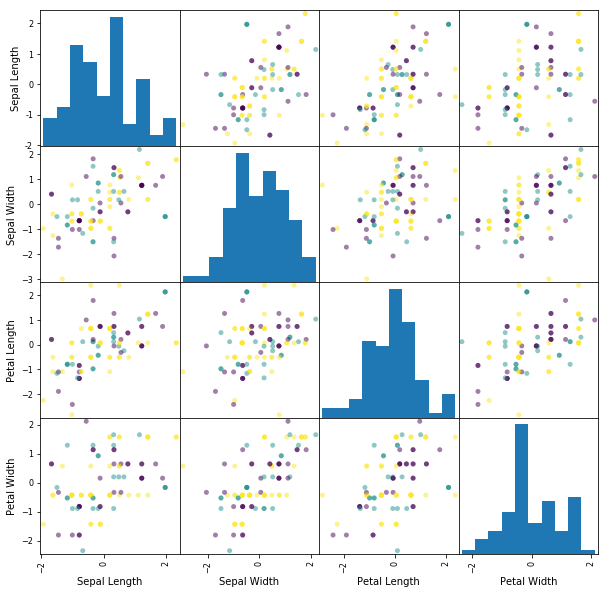

In [48]:
colors = pd.factorize(df_iris['Name'])[0]  # get numeric class value for each row
pl5 = pd.plotting.scatter_matrix(df_iris, c=colors, figsize=(10, 10), s=100)

Depending on the objectives, these changes could be beneficial or detrimental. The use of data sampling, outlier removal, and data normalization are steps that depend critically on the purpose of analysis and the methods being employed.

## Feature Selection

Feature selection is the process of reducing the number of random variables (features) under consideration by creating a subset. Feature selection can help to reduce computational load and improve inference by eliminating features that are not sufficiently useful. Here, we demonstrate feature selection using mutual information on the Iris dataset.

sklearn provides several methods for identifying useful features and performing feature selection. Let's import `mutual_info_classif`, a method for identifying useful classification features, and `SelectKBest`, a method for selecting the top-k features ranked by their estimated usefulness.

In [49]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

Now let's load and take a look at the Iris dataset again.

In [50]:
file_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
names = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Name']
df_iris = pd.read_csv(file_url, names=names, header=None)
df_iris.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Let's separate the Iris dataset into the features and the class. The class is the column we are interested in predicting, here the name of the flower. The features are the columns we would like to use to predict the class, here measurements of different parts of the flowers. Borrowing from statistics terminology, we typically denote the class as `y` (dependent variable) and the features as `X` (independent variables).

In [51]:
X = df_iris.iloc[:, :-1]
y = df_iris.iloc[:, -1]

Mutual information is a measure of the mutual dependence between two variables. It quantifies the amount of information obtained about one variable, here the dependent variable (`y`), through another random variable, here the independent variable (`X`). Let's calculate the mutual information between the features `X` and the class variable `y` using the method we imported:

In [52]:
mi = mutual_info_classif(X, y)
mi

array([0.47224956, 0.2589742 , 0.99058367, 0.9902375 ])

Each element of the output list represents the amount of "information" the corresponding feature gives about the class. Since we have 4 features, we have 4 values. The higher the amount of information, the more informative that feature is with respect to our class variable. We can then uses these as scores by which to select features, only keeping the top k features as measured by this score. Let's set `k=2`, to keep only the top 2 features:

In [53]:
# Select the k best features.
selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X, y)

# Get indices of columns to keep.
idxs_selected = selector.get_support(indices=True)

# Create new DataFrame with only desired columns.
X_new = X.iloc[:, idxs_selected]

# Show the top 2 features.
X_new.head()

,Petal Length,Petal Width
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2


According to mutual information, the 2 most informative features are `Petal Length` and `Petal Width`.

## Dimensionality Reduction

Dimensionality reduction is the process of reducing the number of random variables (features) under consideration by creating a new set of features, typically smaller than the previous set. The process of dimensionality reduction has a variety of data science applications. Here, we demonstrate dimensionality reduction using PCA and LLE on the Optical Recognition of Handwritten Digits dataset.

To begin, let's import some libraries we will be needing:

In [54]:
# PCA code modified from http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
from sklearn import datasets, decomposition, manifold, random_projection
from mpl_toolkits.mplot3d import Axes3D

Now, let's load the Optical Recognition of Handwritten Digits dataset (hereafter referred to as the "digits" dataset), which is composed of handwritten digits between 0 and 9 stretched into a rectangular 8x8 box. More information on this dataset can found [here](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits).

Conveniently, scikit-learn has a predefined function to help us load this dataset. Here, we load 6 classes (the digits 0 through 5), setting the explanatory (or independent or feature) variables as X, and the target (or dependent or class) variable as y.

In [55]:
# Load the digits dataset.

digits = datasets.load_digits(n_class=6)  # load the dataset with 6 classes (digits 0 through 5)
X = pd.DataFrame(digits.data)  # explanatory (or independent or feature) variables
y = pd.Series(digits.target)  # target (or dependent or class) variable
n_samples, n_features = X.shape  # the number of rows (samples) and columns (features)

Let's see what this dataset looks like. To do this, we transform the rows (which each have 64 features, representing the individual pixels that comprise the image of a digit) into an 8x8 segment of an array, which we then plot as a figure. We do this for the first 400 digits (rows) in the dataset.

Text(0.5,1,'A Selection from the 64-Dimensional Digits Dataset\n')

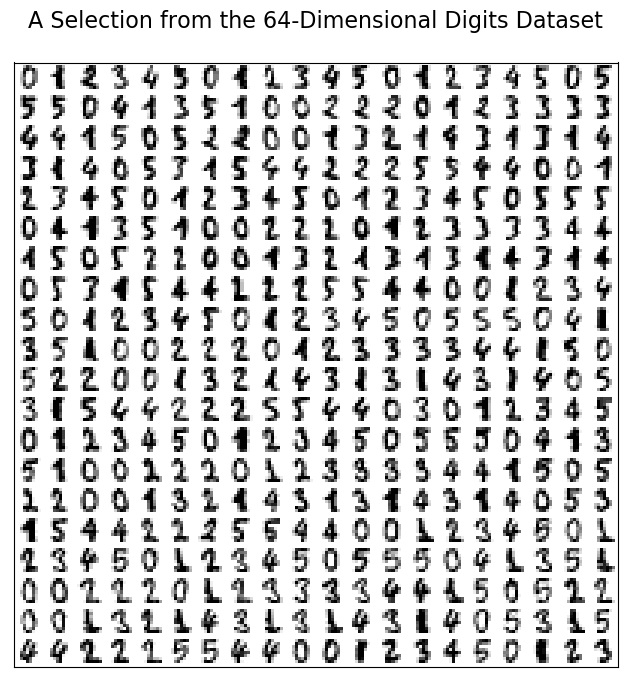

In [56]:
# Plot images of the digits.

n_img_per_row = 20  # number of digits per row
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))  # generate a new array filled with zeros
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        # Set each 8x8 area of the img to the values of each row (reshaped from 1x64 to 8x8).
        img[ix:ix + 8, iy:iy + 8] = X.iloc[i * n_img_per_row + j].values.reshape((8, 8))

plt.figure(figsize=(8, 8), dpi=100)  # define a figure, with size (width and height) and resolution
#axes(frameon=0)  # remove the frame/border from the axes
plt.imshow(img, cmap=plt.cm.binary)  # show the image using a binary color map
plt.xticks([])  # no x ticks
plt.yticks([])  # no y ticks
plt.title('A Selection from the 64-Dimensional Digits Dataset\n', fontsize=16)

Now we would like to perform some dimensionality reduction on this dataset and visualize the results of these transformations. We can combine the visualization process for various dimensionality reduction techniques into a single function. The plot embedding function defined below takes care of details related to the visualization of the results of dimensionality reduction techniques when run on the digits dataset. In our visualization, each digit will be displayed using a different color within the reduced feature space.

Generally, PCA requires centering the data (i.e., subtracting the mean from each data point for each feature), because otherwise the first component may not truly describe the largest direction of variation in the data, but rather the mean of the data.

In [57]:
# Scale and visualize the embedding vectors.

def plot_embedding(X, title=None):
    # min-max normalization
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 6), dpi=100)
    ax = plt.subplot(111)
    ax.axis('off')
    ax.patch.set_visible(False)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]), color=plt.cm.Set1(y[i] / 10.), 
                fontdict={'weight': 'bold', 'size': 12})

    if hasattr(matplotlib.offsetbox, 'AnnotationBbox'):
        # Only print thumbnails with matplotlib > 1.0.
        shown_images = np.array([[1., 1.]])
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 5e-3:
                # Don't show points that are too close together.
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = matplotlib.offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r, zoom=1.25)
            ab = matplotlib.offsetbox.AnnotationBbox(imagebox, X[i])
            ax.add_artist(ab)
    plt.xticks([]), plt.yticks([])
    plt.ylim([-0.1, 1.1])
    plt.xlim([-0.1, 1.1])

    if title is not None:
        plt.title(title, fontsize=16)

Now that we have a means of easily visualizing the results of dimensionality reduction, let's generate a random projection of the dataset into fewer dimensions and visualize the results. Here, we are reducing the dataset from 64 features (or dimensions) to 2, and visualizing how similar the digits are to one another when represented by these 2 features. We can generate this projection using a sparse random projection, which projects the original input (feature) space using a sparse random matrix. As a result, we can view the data along 2 new dimensions (or axes), which have been randomly generated. Digits that are closer together in this 2-dimensional space have values that are more similar along these two axes. Note that these 2 axes may not correspond to any of the axes defined by the original 64 features. In other words, each dimension here may be viewed as some combination of the original features.

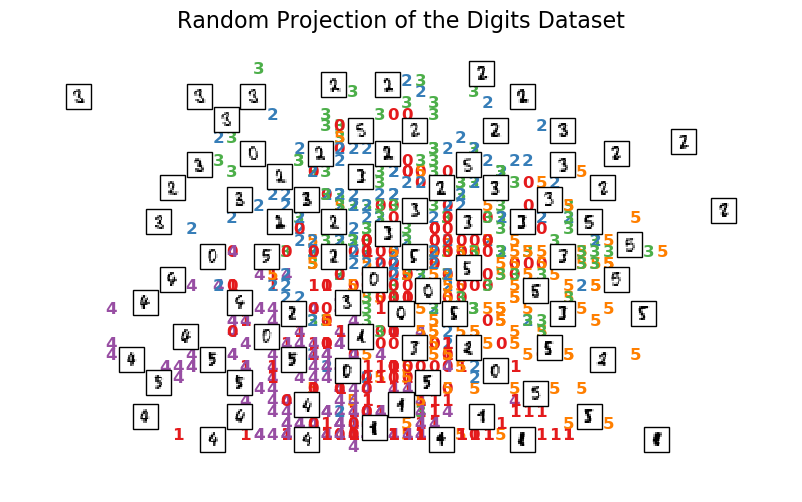

In [58]:
# Random 2D projection using a random unitary matrix.

#print("Computing random projection"),
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
#print("done.")

# Plot random projection result.
plot_embedding(X_projected, "Random Projection of the Digits Dataset")

### Principal Component Analysis (PCA)

Now, let's perform principal component analysis (PCA) to project the data into fewer dimensions. In PCA, the projection is defined by principal components (eigenvectors), each of which can be viewed as a linear combination of the original features that corresponds to a dimension in the projection. The projection is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to (i.e., uncorrelated with) the preceding components. Each principal component (eigenvector) is associated with an eigenvalue, which corresponds to the amount of the variance explained by that component.

Dimensionality reduction is a one-way transformation that induces a loss of information. We can try to minimize the loss of information while retaining the benefits of dimensionality reduction by trying to find the number of principal components needed to effectively represent the original dataset. This number can often be determined by the "elbow" or "knee" point, which is considered to be the natural break between the useful principal components (or dimensions) and residual noise. We can find the elbow point by computing PCA on our dataset and observing the number of principal components after which the amount of variance explained displays a natural break or drop-off.

Since performing PCA on our dataset will generate so many principal components, here we only look at the amount of variance explained by the first 8 components.

In [59]:
# Projection onto the first 8 principal components.

# Global centering.
X_centered = X - X.mean()
    
#print("Computing PCA projection..."),
pca = decomposition.PCA(n_components=8)
X_pca = pca.fit_transform(X_centered)
#print("done.")

print(pca.explained_variance_ratio_)

[0.19268752 0.16491423 0.11496179 0.08523838 0.05260763 0.04703751
 0.03596583 0.03111204]


We can generate a bar plot to help visualize these results. More precisely, here our bar plot is considered a scree plot, which graphs the eigenvalue (each of which correspond to an amount of explained variance) against the component number (each of which correspond to a dimension or axis) to help determine an appropriate number of principal components. To determine the appropriate number of components, we look for an "elbow" in the scree plot, the point at which the remaining eigenvalues are relatively small and all about the same size.

In our scree plot, we can see that there is a relatively large drop-off in the explained variance after the second component. We can consider this to be the elbow point. Note that we simply color the bars in the scree plot for aesthetic purposes.

Text(0.5,1,'Scree Plot for the Digits Dataset')

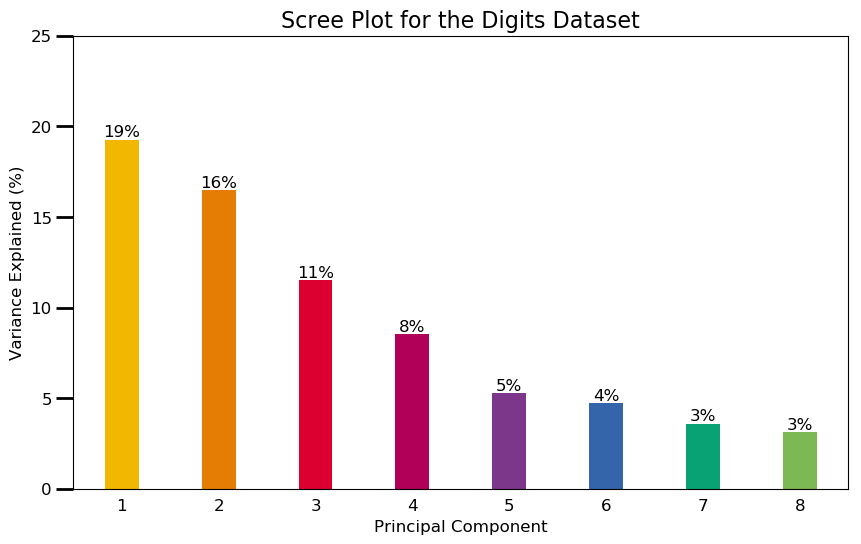

In [60]:
# Generate scree plot.

N = 8
ind = np.arange(N)  # x locations for the groups
vals = pca.explained_variance_ratio_ * 100  # explained variance values

plt.figure(figsize=(10, 6), dpi=100)
ax = plt.subplot(111)

ax.bar(ind, vals, 0.35, 
       color=[(0.949, 0.718, 0.004),
              (0.898, 0.49, 0.016),
              (0.863, 0, 0.188),
              (0.694, 0, 0.345),
              (0.486, 0.216, 0.541),
              (0.204, 0.396, 0.667),
              (0.035, 0.635, 0.459),
              (0.486, 0.722, 0.329),
             ])

params = {'va': 'bottom', 'ha': 'center', 'fontsize': 12}
for i in range(len(vals)):
    ax.annotate(r"%d%%" % (int(vals[i])), (ind[i], vals[i]), **params)

ax.set_xticklabels(range(9), fontsize=12)
ax.set_yticklabels(range(0, 30, 5), fontsize=12)
ax.set_ylim(0, 25)
ax.set_xlim(0 - 0.5, 8 - 0.5)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component", fontsize=12)
ax.set_ylabel("Variance Explained (%)", fontsize=12)

plt.title("Scree Plot for the Digits Dataset", fontsize=16)

Based upon the scree plot, we can see that retaining 2 components seems appropriate for this dataset. Thus, we can perform PCA again, this time only retaining the top 2 components (alternatively, we could simply remove the remaining components from the original PCA computation). Conveniently, the 2 remaining principal components correspond to 2 dimensions or axes, which we can easily visualize using the plot embedding function we defined previously.

Notice that the 2 dimensions generated by PCA (displayed below) seem to organize the data more effectively than the random projection we initially performed.

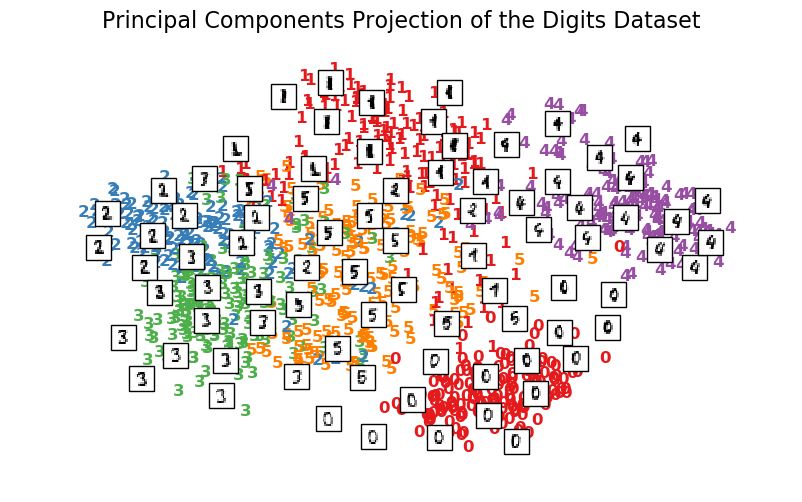

In [61]:
# Compute (two-dimensional) PCA on the digits dataset.

#print("Computing PCA projection..."),
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X)
#print("done.")

# Plot PCA result.
plot_embedding(X_pca, "Principal Components Projection of the Digits Dataset")

### Locally Linear Embedding (LLE)

As might be expected, PCA is not the only method for reducing the dimensionality of a dataset. Another popular method we may use to project our dataset into 2 dimensions is known as locally linear embedding (LLE). LLE finds a set of the nearest neighbors of each point, computes a set of weights for each point that best describe the point as a linear combination of its neighbors, and then finds the low-dimensional embedding of points such that each point is still described with the same linear combination of its neighbors. Whereas in PCA each principal component is a straight line along which the data's projections have the most variance, LLE performs a different linear dimensionality reduction at each point (because locally a manifold appears linear) and then combines these linear representations with minimal discrepancy to approximate non-linear structure.

The 2 dimensions generated by LLE (using a set of 30 nearest neighbors for each point) are displayed below. Notice that, given that our digits dataset doesn't have any particular non-linear structure (i.e., the digits are oriented the same way), the organization of the projection doesn't appear to be better (and may even be worse) than that generated by PCA.

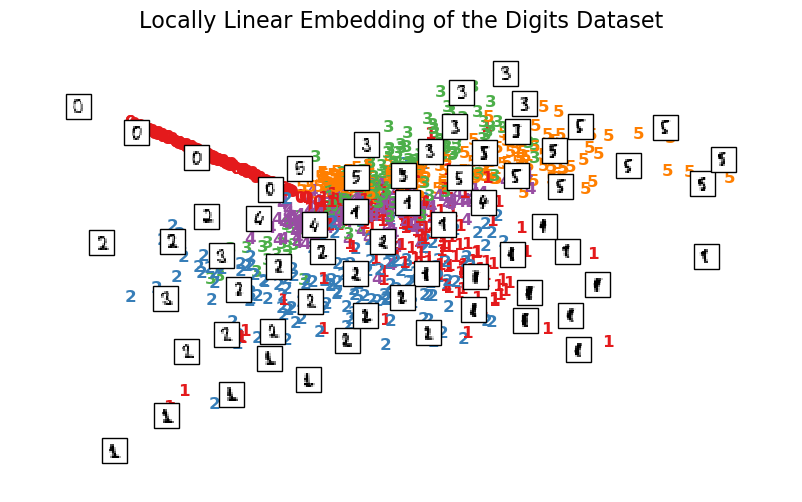

In [62]:
# Compute (two-dimensional) LLE on the digits dataset.

#print("Computing LLE..."),
clf = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=2, method='standard')
X_lle = clf.fit_transform(X)
#print("done. Reconstruction error: %g" % clf.reconstruction_error_)

# Plot LLE result.
plot_embedding(X_lle, "Locally Linear Embedding of the Digits Dataset")

Let's see how LLE performs on a dataset with predominantly non-linear structure. Conveniently, scikit-learn provides a function to generate a Swiss roll, a 3-dimensional non-linear dataset that resembles the culinary delight of the same name. Here, we generate a Swiss roll dataset of 1,500 points.

In [63]:
# Generate the Swiss roll.

X, color = datasets.samples_generator.make_swiss_roll(n_samples=1500)

We can visualize the Swiss roll dataset using a 3-dimensional figure. 

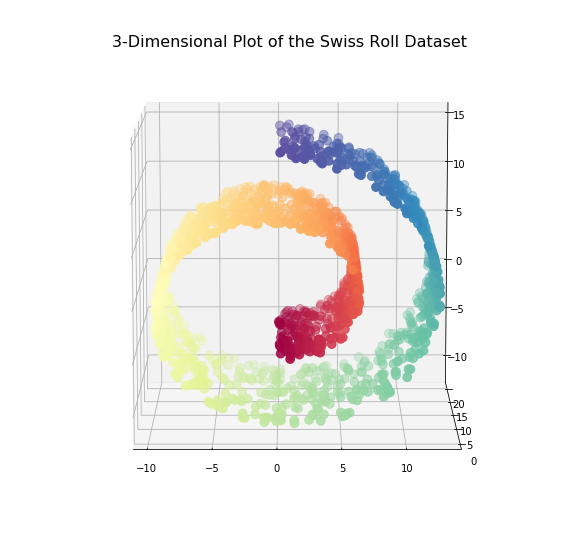

In [64]:
# Plot the Swiss roll.

fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(111, projection='3d')

ax.azim = -90
ax.elev = 10
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=75, c=color, cmap=plt.cm.Spectral)

plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)

plt.axis('scaled')

out = plt.title("3-Dimensional Plot of the Swiss Roll Dataset", fontsize=16)

Now we compute LLE on this dataset, retaining just 2 dimensions, which we plot as a figure. Notice how the 3-dimensional structure of the points (that is, similarly-colored points being close together) is maintained by the 2-dimensional LLE projection.

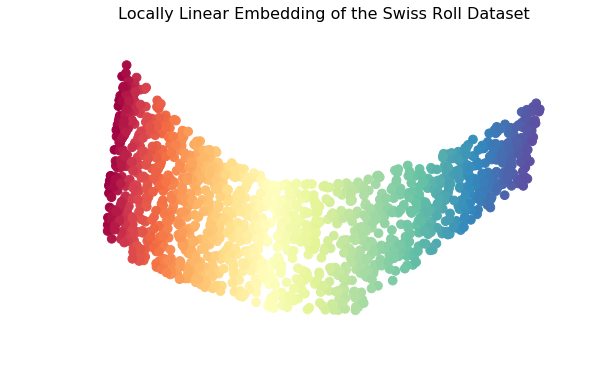

In [65]:
# Compute (two-dimensional) LLE on the Swiss roll dataset.

#print("Computing LLE..."),
X_r, err = manifold.locally_linear_embedding(X, n_neighbors=12, n_components=2)
#print("done. Reconstruction error: %g" % err)

# Plot LLE result.
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)

ax.scatter(X_r[:, 0], X_r[:, 1], s=75, c=color, cmap=plt.cm.Spectral)
plt.axis('off')

out = plt.title("Locally Linear Embedding of the Swiss Roll Dataset", fontsize=16)

Now we compute PCA on this dataset, retaining just 2 dimensions, which we plot as a figure. Notice how the 3-dimensional structure of the points (that is, similarly-colored points being close together) is not maintained by the 2-dimensional PCA projection. Instead, the structure is lost, with the points appearing relatively disorganized. This is because PCA cannot account for the non-linear structure (the curvature) of this dataset, whereas LLE can account for this property. You can think of LLE as unraveling the Swiss roll, whereas PCA is flattening it. 

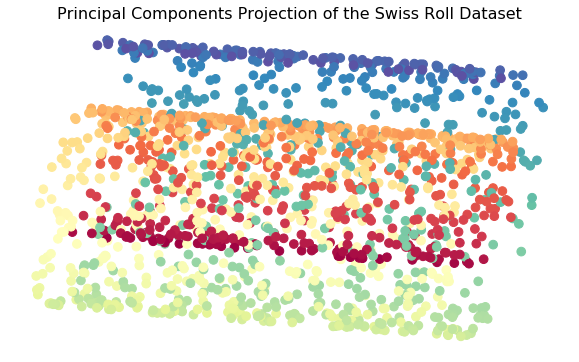

In [66]:
# Compute (two-dimensional) PCA on the Swiss roll dataset.

#print("Computing PCA..."),
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
#print("done.")

# Plot PCA result.

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)

ax.scatter(X_pca[:, 0], X_pca[:, 1], s=75, c=color, cmap=plt.cm.Spectral)
plt.axis('off')
plt.xticks([]), plt.yticks([])

out = plt.title("Principal Components Projection of the Swiss Roll Dataset", fontsize=16)